Lambda School Data Science

*Unit 2, Sprint 2, Module 3*

---

# Cross-Validation


## Assignment
- [X] [Review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [X] Continue to participate in our Kaggle challenge. 
- [X] Use scikit-learn for hyperparameter optimization with RandomizedSearchCV.
- [X] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [X] Commit your notebook to your fork of the GitHub repo.


You won't be able to just copy from the lesson notebook to this assignment.

- Because the lesson was ***regression***, but the assignment is ***classification.***
- Because the lesson used [TargetEncoder](https://contrib.scikit-learn.org/categorical-encoding/targetencoder.html), which doesn't work as-is for _multi-class_ classification.

So you will have to adapt the example, which is good real-world practice.

1. Use a model for classification, such as [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
2. Use hyperparameters that match the classifier, such as `randomforestclassifier__ ...`
3. Use a metric for classification, such as [`scoring='accuracy'`](https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values)
4. If you’re doing a multi-class classification problem — such as whether a waterpump is functional, functional needs repair, or nonfunctional — then use a categorical encoding that works for multi-class classification, such as [OrdinalEncoder](https://contrib.scikit-learn.org/categorical-encoding/ordinal.html) (not [TargetEncoder](https://contrib.scikit-learn.org/categorical-encoding/targetencoder.html))



## Stretch Goals

### Reading
- Jake VanderPlas, [Python Data Science Handbook, Chapter 5.3](https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html), Hyperparameters and Model Validation
- Jake VanderPlas, [Statistics for Hackers](https://speakerdeck.com/jakevdp/statistics-for-hackers?slide=107)
- Ron Zacharski, [A Programmer's Guide to Data Mining, Chapter 5](http://guidetodatamining.com/chapter5/), 10-fold cross validation
- Sebastian Raschka, [A Basic Pipeline and Grid Search Setup](https://github.com/rasbt/python-machine-learning-book/blob/master/code/bonus/svm_iris_pipeline_and_gridsearch.ipynb)
- Peter Worcester, [A Comparison of Grid Search and Randomized Search Using Scikit Learn](https://blog.usejournal.com/a-comparison-of-grid-search-and-randomized-search-using-scikit-learn-29823179bc85)

### Doing
- Add your own stretch goals!
- Try other [categorical encodings](https://contrib.scikit-learn.org/categorical-encoding/). See the previous assignment notebook for details.
- In additon to `RandomizedSearchCV`, scikit-learn has [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). Another library called scikit-optimize has [`BayesSearchCV`](https://scikit-optimize.github.io/notebooks/sklearn-gridsearchcv-replacement.html). Experiment with these alternatives.
- _[Introduction to Machine Learning with Python](http://shop.oreilly.com/product/0636920030515.do)_ discusses options for "Grid-Searching Which Model To Use" in Chapter 6:

> You can even go further in combining GridSearchCV and Pipeline: it is also possible to search over the actual steps being performed in the pipeline (say whether to use StandardScaler or MinMaxScaler). This leads to an even bigger search space and should be considered carefully. Trying all possible solutions is usually not a viable machine learning strategy. However, here is an example comparing a RandomForestClassifier and an SVC ...

The example is shown in [the accompanying notebook](https://github.com/amueller/introduction_to_ml_with_python/blob/master/06-algorithm-chains-and-pipelines.ipynb), code cells 35-37. Could you apply this concept to your own pipelines?


### BONUS: Stacking!

Here's some code you can use to "stack" multiple submissions, which is another form of ensembling:

```python
import pandas as pd

# Filenames of your submissions you want to ensemble
files = ['submission-01.csv', 'submission-02.csv', 'submission-03.csv']

target = 'status_group'
submissions = (pd.read_csv(file)[[target]] for file in files)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]

sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission[target] = majority_vote
submission.to_csv('my-ultimate-ensemble-submission.csv', index=False)
```

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [2]:
import pandas as pd
import numpy as np

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [3]:
import pandas_profiling

profile_report = train.profile_report(
    check_correlation_pearson=False,
    correlations={
        'pearson': False,
        'spearman': False,
        'kendall': False,
        'phi_k': False,
        'cramers': False,
        'recoded': False,
    },
    plot={'histogram': {'bayesian_blocks_bins': False}},
)

profile_report

In [4]:
def preprocess(X):
    """
    Preprocess the data by changing datatypes for certain
    rows and handling data abnormalities by converting to
    NaN.
    """
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # Empty strings and unknowns should be treated as NaN
    nan_strings = ['', 'unknown', 'Unknown']
    X = X.replace(to_replace=nan_strings, value=np.nan)
    
    # Change date_recorded to datetime object
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Because region_code and district_code are categorical and not numeric data,
    # we should convert them to strings.
    X['region_code'] = X['region_code'].apply(str)
    X['district_code'] = X['district_code'].apply(str)
    
    # The public_meeting and permit columns are boolean, so they should
    # act as such in the dataframe.
    X['public_meeting'] = X['public_meeting'].astype(bool)
    X['permit'] = X['permit'].astype(bool)
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zeroes.
    near_zero = X['latitude'] > -1e-04
    X.loc[near_zero, 'latitude'] = 0
    
    near_zero = X['longitude'] < 1e-04
    X.loc[near_zero, 'longitude'] = 0
    
    # When columns have zeros and don't make sense, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    cols_with_zeros = ['amount_tsh', 'gps_height', 'longitude',
                       'latitude', 'population', 'construction_year']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
    
    # Convert the categorical columns to lowercase to account for possible
    # random capitalizations.
    categorical = X.select_dtypes(exclude=['number', 'bool', 'datetime']).columns.tolist()
    
    for feature in categorical:
        X[feature] = X[feature].str.lower()
        
    # Drop the following columns because they add nothing to the data for analysis
    # id - constantly varies, we can already ID by index
    # recorded_by - constant value, does not help predict status_group
    to_drop = ['id', 'recorded_by']
    X = X.drop(columns=to_drop)
    
    return X

train = preprocess(train)
test = preprocess(test)

In [5]:
def impute_values(X):
    """
    Impute some values in the training set in a custom way.
    """
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # Process the location data:
    # Replace the missing longitude and latitude with the in-district mean.
    X['longitude'] = X.groupby(['region','district_code']).transform(lambda x: x.fillna(x.mean()))['longitude']
    X['latitude'] = X.groupby(['region','district_code']).transform(lambda x: x.fillna(x.mean()))['latitude']
    
    # If the district has missing data, then use the region mean.
    X['longitude'] = X.groupby('region').transform(lambda x: x.fillna(x.mean()))['longitude']
    X['latitude'] = X.groupby('region').transform(lambda x: x.fillna(x.mean()))['latitude']
    
    # lga has values that specify rural, urban, and other
    # Transform the specified ones to rural/urban and
    # unspecified ones to other
    rural = X['lga'].str.contains(' rural')
    urban = X['lga'].str.contains(' urban')
    X.loc[rural, 'lga'] = 'rural'
    X.loc[urban, 'lga'] = 'urban'
    X.loc[~(rural | urban), 'lga'] = 'other'
    
    # Combine smaller separations in extraction_type
    replace_dict = {
        'india mark ii': 'india mark',
        'india mark iii': 'india mark',
        'other - mkulima/shinyanga': 'other handpump',
        'other - play pump': 'other handpump',
        'walimi': 'other handpump',
        'other - swn 81': 'swn',
        'swn 80': 'swn',
        'cemo': 'other motorpump',
        'climax': 'other motorpump'
    }
    X['extraction_type'] = X['extraction_type'].replace(replace_dict)
    
    # Extract top x values from remaining categorical features:
    # funder, installer, wpt_name
    cols = ['funder', 'installer', 'wpt_name']
    for c in cols:
        reduce_cardinality(X, c)
    
    # Return the dataframe with imputed features
    return X


def reduce_cardinality(df, col, n=10, size=500):
    '''
    Reduce the cardinality of certain features beyond a size threshold.
    '''
    
    # Get the list of observations with more than size
    big_enough = df[col].value_counts() >= size
    big_enough_col = big_enough.index
    
    # For observations that are smaller, replace with 'other'
    df.loc[~df[col].isin(big_enough_col), col] = 'other'
    
    # Get the list of the top n observations
    top_n = df[col].value_counts()[:n].index
    
    # For observations not in the top 10, replace with 'other'
    df.loc[~df[col].isin(top_n), col] = 'other'

# We can't impute values on the test set! Otherwise data leakage
train = impute_values(train)

In [6]:
def engineer_features(X):
    """Engineer features for train and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # Create a "missing indicator" column, because the fact that
    # values are missing may be a predictive signal.
    cols_with_nans = ['amount_tsh', 'gps_height', 'population']
    for col in cols_with_nans:
        X[col+'_MISSING'] = X[col].isnull()
        
    # Drop the following columns:
    # amount_tsh - over 70% of the values are NaN
    # ward
    # subvillage
    # region_code
    # district_code <--- The relevant location data is extracted above
    # extraction_type_group - separation is better in extraction_type
    # scheme_name - cardinality too high
    # payment - duplicate of payment_type
    # quality_group - water_quality is slightly more precise
    # quantity_group - duplicate of quantity
    # source_type - source_class and source are general/granular enough
    # waterpoint_type_group - less detailed than waterpoint_type
    X = X.drop(columns=['scheme_name', 'payment', 'quality_group',
                        'quantity_group', 'source_type', 'ward',
                        'extraction_type_group', 'subvillage',
                        'waterpoint_type_group', 'region_code',
                        'district_code', 'amount_tsh'])
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_of_year_recorded'] = X['date_recorded'].dt.dayofyear
    X = X.drop(columns='date_recorded')
    
    # Engineer feature: rainy season depending on month, then drop the month column
    # https://www.tripsavvy.com/tanzania-weather-and-average-temperatures-4071465
    condition1 = X['month_recorded'] <= 2
    condition2 = (X['month_recorded'] > 2) & (X['month_recorded'] <= 5)
    condition3 = (X['month_recorded'] > 5) & (X['month_recorded'] <= 10)
    condition4 = (X['month_recorded'] > 10) & (X['month_recorded'] <= 12)
    X.loc[condition1, 'season'] = 'short dry'
    X.loc[condition2, 'season'] = 'long rainy'
    X.loc[condition3, 'season'] = 'long dry'
    X.loc[condition4, 'season'] = 'short rainy'
    X = X.drop(columns='month_recorded')
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['years'] = X['year_recorded'] - X['construction_year']
    condition = X['years'] < 0
    X.loc[condition, 'years'] = np.nan  # replace negative years with NaN
    X['years_MISSING'] = X['years'].isnull()
    X = X.drop(columns=['year_recorded', 'construction_year'])
    
    # Return the dataframe with new features
    return X

train = engineer_features(train)
test = engineer_features(test)

In [7]:
# The status_group column is the target
target = 'status_group'

# Get a dataframe with all train columns except the target and take the column names
features = train.drop(columns=[target]).columns.tolist()

In [63]:
# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_test = test[features]

In [9]:
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from time import time

In [10]:
# Fit pipeline on GridSearchCV
pipe = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(n_estimators=1000,
                           max_features=10,
                           random_state=42,
                           n_jobs=-1)
)

# Fit the cross-validation on train
t0 = time()
pipe.fit(X_train, y_train)
print(f'Done in {(time()-t0):0.3f}s\n')

# Score on train, val
print('Train Accuracy:', pipe.score(X_train, y_train))

Done in 49.637s

Train Accuracy: 0.9982996632996634


In [11]:
import category_encoders as ce
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

features = train.columns.drop(target)
X_train = train[features]
y_train = train[target]

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(max_depth=None, n_estimators=100, random_state=42, n_jobs=-1)
)

param_distributions = {
    'randomforestclassifier__max_features': uniform(0,1),
    'randomforestclassifier__max_depth': [20, None]
}

# If you're on Colab, decrease n_iter & cv parameters
search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=12, 
    cv=4, 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(X_train, y_train);

Fitting 4 folds for each of 12 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   51.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  46 out of  48 | elapsed:  4.5min remaining:   11.6s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  4.5min finished


In [12]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation accuracy', search.best_score_)

Best hyperparameters {'randomforestclassifier__max_depth': 20, 'randomforestclassifier__max_features': 0.19290882035005907}
Cross-validation accuracy 0.8103535353535354


In [13]:
pd.DataFrame(search.cv_results_).sort_values(by='rank_test_score').T

,6,9,3,8,5,1,0,10,2,4,11,7
mean_fit_time,7.40386,10.8925,17.8509,9.54516,24.2423,13.2387,29.6928,16.8687,21.6185,20.7875,26.9521,23.4778
std_fit_time,0.624427,0.594768,0.4621,0.515988,0.706405,0.599258,0.99642,0.757357,0.599813,0.760137,1.05139,0.790958
mean_score_time,1.47567,1.29549,1.20791,1.46265,1.20115,1.33128,1.27072,1.44614,1.21191,1.27222,1.47517,1.45765
std_score_time,0.548617,0.629842,0.450113,0.649913,0.52017,0.41904,0.438355,0.692342,0.482476,0.427112,0.598418,0.711122
param_randomforestclassifier__max_depth,20,20,20,None,20,None,20,None,None,None,None,None
param_randomforestclassifier__max_features,0.192909,0.321757,0.552734,0.249611,0.806049,0.384365,0.968208,0.502009,0.66876,0.625085,0.850003,0.724508
params,"{'randomforestclassifier__max_depth': 20, 'ran...","{'randomforestclassifier__max_depth': 20, 'ran...","{'randomforestclassifier__max_depth': 20, 'ran...","{'randomforestclassifier__max_depth': None, 'r...","{'randomforestclassifier__max_depth': 20, 'ran...","{'randomforestclassifier__max_depth': None, 'r...","{'randomforestclassifier__max_depth': 20, 'ran...","{'randomforestclassifier__max_depth': None, 'r...","{'randomforestclassifier__max_depth': None, 'r...","{'randomforestclassifier__max_depth': None, 'r...","{'randomforestclassifier__max_depth': None, 'r...","{'randomforestclassifier__max_depth': None, 'r..."
split0_test_score,0.813481,0.814625,0.811865,0.811259,0.809036,0.808969,0.805939,0.808767,0.806882,0.807488,0.805131,0.805198
split1_test_score,0.811246,0.810034,0.810034,0.808148,0.808081,0.806061,0.808687,0.807609,0.805522,0.804714,0.805791,0.803906
split2_test_score,0.807811,0.806599,0.804579,0.803771,0.803973,0.803569,0.801279,0.801279,0.802492,0.800067,0.801212,0.800471


In [14]:
from xgboost.sklearn import XGBClassifier
from scipy.stats import beta, expon

one_to_left = beta(10, 1)
from_zero_positive = expon(0, 50)

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    XGBClassifier(objective='multi:softprob', eval_metric='merror', seed=42)
)

param_distributions = {
    'xgbclassifier__n_estimators': randint(3, 40),
    'xgbclassifier__max_depth': randint(3, 40),
    'xgbclassifier__learning_rate': uniform(0.05, 0.4),
    'xgbclassifier__colsample_bytree': one_to_left,
    'xgbclassifier__subsample': one_to_left,
    'xgbclassifier__gamma': uniform(0, 10),
    'xgbclassifier__reg_alpha': from_zero_positive,
    'xgbclassifier__min_child_weight': from_zero_positive,
}

# If you're on Colab, decrease n_iter & cv parameters
search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=100, 
    cv=3, 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-2
)

search.fit(X_train, y_train);

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done   2 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-2)]: Done   7 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-2)]: Done  12 tasks      | elapsed:   36.4s
[Parallel(n_jobs=-2)]: Done  19 tasks      | elapsed:   59.6s
[Parallel(n_jobs=-2)]: Done  26 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-2)]: Done  35 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-2)]: Done  55 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-2)]: Done  66 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-2)]: Done  79 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-2)]: Done  92 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-2)]: Done 107 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-2)]: Done 122 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-2)]: Done 139 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-2)]: Done 156 tasks      | elapsed:  7

In [15]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation accuracy', search.best_score_)
print(pipeline.named_steps['xgbclassifier'])

Best hyperparameters {'xgbclassifier__colsample_bytree': 0.941495750400699, 'xgbclassifier__gamma': 0.6989475645952481, 'xgbclassifier__learning_rate': 0.43409308586561685, 'xgbclassifier__max_depth': 25, 'xgbclassifier__min_child_weight': 26.812515970831956, 'xgbclassifier__n_estimators': 29, 'xgbclassifier__reg_alpha': 5.419727800697178, 'xgbclassifier__subsample': 0.8995107054120757}
Cross-validation accuracy 0.798047138047138
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='merror',
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=-1, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


In [16]:
pd.DataFrame(search.cv_results_).sort_values(by='rank_test_score').T

,91,10,11,19,77,87,57,22,83,94,...,67,97,35,26,61,18,41,28,38,58
mean_fit_time,12.4193,14.1936,17.0163,16.706,9.92519,9.85813,15.672,12.4723,8.332,12.0346,...,2.70793,3.26614,3.06761,1.8441,2.04096,7.33504,3.77396,4.4089,2.45035,1.92118
std_fit_time,0.200367,0.222025,0.214665,0.705361,0.376635,0.129329,0.176912,0.278297,0.148576,0.14389,...,0.126995,0.071438,0.160696,0.185515,0.10584,0.0737324,0.075986,0.275358,0.350476,0.0741942
mean_score_time,0.341328,0.365017,0.27026,0.416734,0.291614,0.331985,0.278936,0.344998,0.268592,0.316305,...,0.223548,0.232223,0.253911,0.21821,0.212871,0.258582,0.214206,0.276266,0.247238,0.214207
std_score_time,0.00216314,0.0106658,0.00356218,0.0967453,0.00954316,0.0181707,0.00262689,0.0276591,0.0272215,0.0134559,...,0.0446469,0.0464124,0.0295171,0.0193231,0.0358606,0.0279601,0.0109949,0.0425701,0.0141793,0.0377015
param_xgbclassifier__colsample_bytree,0.941496,0.858525,0.995047,0.933693,0.942881,0.84072,0.8797,0.92814,0.908286,0.849715,...,0.831418,0.999287,0.621987,0.74198,0.813491,0.90603,0.949876,0.80621,0.933883,0.822213
param_xgbclassifier__gamma,0.698948,2.33177,8.09665,6.45902,3.02852,0.22174,8.99417,2.55456,2.39541,0.693434,...,1.81138,7.82394,4.11819,8.38075,2.69646,1.60458,5.37986,4.31921,2.24337,5.12506
param_xgbclassifier__learning_rate,0.434093,0.280664,0.426617,0.0862004,0.15258,0.304148,0.324273,0.317003,0.431779,0.389768,...,0.160127,0.14164,0.191208,0.248754,0.124323,0.0626084,0.176241,0.0560513,0.276373,0.174037
param_xgbclassifier__max_depth,25,35,35,32,36,15,37,39,21,33,...,11,4,4,9,11,35,4,21,3,3
param_xgbclassifier__min_child_weight,26.8125,61.912,3.08145,40.8153,21.7896,15.2933,13.2407,99.1417,9.0382,11.6319,...,2.4312,98.3788,5.1247,43.2056,65.1969,36.8512,45.9693,197.591,2.51363,12.5896
param_xgbclassifier__n_estimators,29,38,20,37,25,34,35,39,21,38,...,8,23,18,5,6,31,29,21,12,12


In [72]:
def fit_model(alg, X_train, y_train, use_cv=True,
              cv_folds=5, early_stopping_rounds=50):
    import xgboost as xgb
    from sklearn.metrics import accuracy_score
    
    if use_cv:
        xgb_param = alg.get_xgb_params()
        xgb_param['num_class'] = 3
        xgtrain = xgb.DMatrix(X_train, label=y_train.values)
        cv_result = xgb.cv(xgb_param, xgtrain,
                           num_boost_round=alg.get_params()['n_estimators'],
                           nfold=cv_folds, metrics='merror',
                           verbose_eval=10,
                           early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cv_result.shape[0])
    
    # Fit the algorithm on the data
    alg.fit(X_train, y_train)
    
    # Predict training set
    y_pred = alg.predict(X_train)
    
    # Print model report
    print('\nModel Report')
    print(f'Train Accuracy: {accuracy_score(y_train, y_pred)}')
    
    xgb.plot_importance(alg.get_booster())

[0]	train-merror:0.282146+0.00209031	test-merror:0.2833+0.00530517
[10]	train-merror:0.264848+0.00156039	test-merror:0.267104+0.00503929
[20]	train-merror:0.257294+0.00158578	test-merror:0.261229+0.00495337
[30]	train-merror:0.248948+0.00144542	test-merror:0.253485+0.00477256
[40]	train-merror:0.241734+0.00177065	test-merror:0.248165+0.00471462
[50]	train-merror:0.236052+0.00187519	test-merror:0.242862+0.00437325
[60]	train-merror:0.230598+0.00261356	test-merror:0.238821+0.00406606
[70]	train-merror:0.226604+0.00223989	test-merror:0.235522+0.00462186
[80]	train-merror:0.222365+0.00144419	test-merror:0.232727+0.00506931
[90]	train-merror:0.218775+0.00145257	test-merror:0.230202+0.00480045
[100]	train-merror:0.215492+0.00147799	test-merror:0.227508+0.00460925
[110]	train-merror:0.212609+0.00168143	test-merror:0.225471+0.00448154
[120]	train-merror:0.209785+0.00140033	test-merror:0.224411+0.00492439
[130]	train-merror:0.206961+0.00173217	test-merror:0.222576+0.00456814
[140]	train-merror:

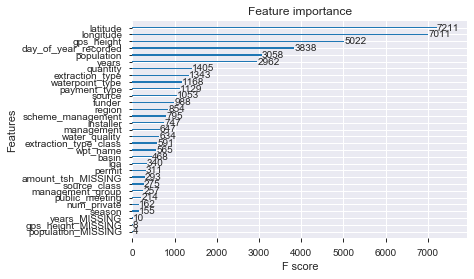

In [73]:
pipe = make_pipeline(
    ce.OrdinalEncoder(), 
)

X_train_transform = pipe.fit_transform(X_train)
replace_dict = {
    'functional': 0,
    'functional needs repair': 1,
    'non functional': 2
}
y_train = y_train.replace(replace_dict)

xgb1 = XGBClassifier(
        learning_rate=0.1,
        n_estimators=1000,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='multi:softprob',
        eval_metric='merror',
        seed=42
)

fit_model(xgb1, X_train_transform, y_train)

In [76]:
xgb1.n_estimators

561

In [81]:
param_test1 = {
    'max_depth': range(3,10,2),
    'min_child_weight': range(1,6,2)
}

rsearch1 = RandomizedSearchCV(
    estimator = XGBClassifier(
        learning_rate=0.1,
        n_estimators=561,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='multi:softprob',
        eval_metric='merror',
        seed=42
    ),
    param_distributions=param_test1,
    n_iter=12,
    cv=5,
    verbose=10,
    return_train_score=True,
    n_jobs=-1
)

rsearch1.fit(X_train_transform, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 21.7min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 25.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 25.9min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=0.8,
                                           eval_metric='merror', gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=5, min_child_weight=1,
                                           missing=None, n_estimators=561,
                                           n_jobs=1, nthread=None,
                                           objective='multi:softprob',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=42, silent=None, subsample=0.8,
 

In [82]:
print('Best hyperparameters', rsearch1.best_params_)
print('Cross-validation accuracy', rsearch1.best_score_)

Best hyperparameters {'min_child_weight': 3, 'max_depth': 9}
Cross-validation accuracy 0.8113804713804714


In [83]:
pd.DataFrame(rsearch1.cv_results_).sort_values(by='rank_test_score').T

,10,9,6,11,7,8,3,4,5,2,0,1
mean_fit_time,133.503,134.843,103.605,130.749,102.652,101.677,74.2971,73.2703,73.3936,46.9747,47.3326,46.8982
std_fit_time,0.545938,0.664159,0.508442,1.55986,0.555465,0.546798,0.408212,0.330087,0.381693,0.28263,0.375334,0.124453
mean_score_time,5.95732,6.89922,2.53323,4.6927,2.50981,2.26237,1.09025,1.05681,1.09365,0.565143,0.567545,0.563341
std_score_time,0.605077,0.748147,0.252133,1.31884,0.287246,0.213327,0.0828502,0.0332489,0.0859861,0.00241901,0.00620284,0.00292861
param_min_child_weight,3,1,1,5,3,5,1,3,5,5,1,3
param_max_depth,9,9,7,9,7,7,5,5,5,3,3,3
params,"{'min_child_weight': 3, 'max_depth': 9}","{'min_child_weight': 1, 'max_depth': 9}","{'min_child_weight': 1, 'max_depth': 7}","{'min_child_weight': 5, 'max_depth': 9}","{'min_child_weight': 3, 'max_depth': 7}","{'min_child_weight': 5, 'max_depth': 7}","{'min_child_weight': 1, 'max_depth': 5}","{'min_child_weight': 3, 'max_depth': 5}","{'min_child_weight': 5, 'max_depth': 5}","{'min_child_weight': 5, 'max_depth': 3}","{'min_child_weight': 1, 'max_depth': 3}","{'min_child_weight': 3, 'max_depth': 3}"
split0_test_score,0.815925,0.814746,0.812305,0.814325,0.811885,0.809275,0.801364,0.8017,0.799259,0.775776,0.775776,0.77544
split1_test_score,0.811969,0.811885,0.810875,0.807592,0.807592,0.807676,0.79867,0.795724,0.798249,0.774935,0.775776,0.775861
split2_test_score,0.81271,0.81271,0.813552,0.81229,0.812037,0.811279,0.80404,0.802357,0.80101,0.777273,0.776094,0.775589


In [84]:
param_test2 = {
    'max_depth': [8,9,10],
    'min_child_weight': [2,3,4]
}

rsearch2 = RandomizedSearchCV(
    estimator = XGBClassifier(
        learning_rate=0.1,
        n_estimators=561,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='multi:softprob',
        eval_metric='merror',
        seed=42
    ),
    param_distributions=param_test2,
    n_iter=9,
    cv=5,
    verbose=10,
    return_train_score=True,
    n_jobs=-1
)

rsearch2.fit(X_train_transform, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 15.4min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 24.0min
[Parallel(n_jobs=-1)]: Done  43 out of  45 | elapsed: 30.8min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 32.9min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=0.8,
                                           eval_metric='merror', gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=5, min_child_weight=1,
                                           missing=None, n_estimators=561,
                                           n_jobs=1, nthread=None,
                                           objective='multi:softprob',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=42, silent=None, subsample=0.8,
 

In [85]:
print('Best hyperparameters', rsearch2.best_params_)
print('Cross-validation accuracy', rsearch2.best_score_)

Best hyperparameters {'min_child_weight': 3, 'max_depth': 9}
Cross-validation accuracy 0.8113804713804714


In [88]:
param_test3 = {
    'gamma': [i/10.0 for i in range(0,5)]
}

rsearch3 = RandomizedSearchCV(
    estimator = XGBClassifier(
        learning_rate=0.1,
        n_estimators=561,
        max_depth=9,
        min_child_weight=3,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='multi:softprob',
        eval_metric='merror',
        seed=42
    ),
    param_distributions=param_test3,
    n_iter=5,
    cv=5,
    verbose=10,
    return_train_score=True,
    n_jobs=-1
)

rsearch3.fit(X_train_transform, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 13.6min
[Parallel(n_jobs=-1)]: Done  21 out of  25 | elapsed: 16.2min remaining:  3.1min
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 18.6min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=0.8,
                                           eval_metric='merror', gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=9, min_child_weight=3,
                                           missing=None, n_estimators=561,
                                           n_jobs=1, nthread=None,
                                           objective='multi:softprob',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=42, silent=None, subsample=0.8,
 

In [89]:
print('Best hyperparameters', rsearch3.best_params_)
print('Cross-validation accuracy', rsearch3.best_score_)

Best hyperparameters {'gamma': 0.0}
Cross-validation accuracy 0.8113804713804714


[0]	train-merror:0.233451+0.00187569	test-merror:0.248855+0.00657142
[10]	train-merror:0.208704+0.00111402	test-merror:0.227997+0.00551228
[20]	train-merror:0.193868+0.00123898	test-merror:0.216936+0.00501287
[30]	train-merror:0.180084+0.000616697	test-merror:0.20904+0.00365248
[40]	train-merror:0.170446+0.000766604	test-merror:0.204562+0.0027309
[50]	train-merror:0.163565+0.00106861	test-merror:0.202004+0.00241118
[60]	train-merror:0.157546+0.00128531	test-merror:0.200017+0.0022536
[70]	train-merror:0.151928+0.0012393	test-merror:0.198805+0.00216554
[80]	train-merror:0.147096+0.00147324	test-merror:0.197256+0.00269399
[90]	train-merror:0.142294+0.00174084	test-merror:0.196397+0.00308929
[100]	train-merror:0.138068+0.00152535	test-merror:0.195337+0.00268132
[110]	train-merror:0.134238+0.00141253	test-merror:0.194613+0.0025735
[120]	train-merror:0.130631+0.00108354	test-merror:0.193973+0.00292812
[130]	train-merror:0.127037+0.00108931	test-merror:0.193064+0.0025893
[140]	train-merror:0.

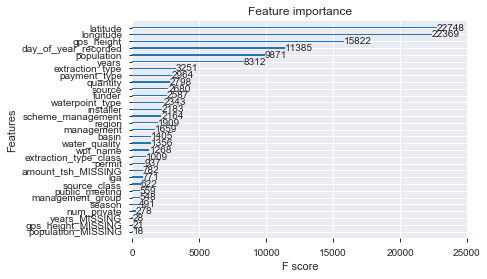

In [90]:
xgb2 = XGBClassifier(
        learning_rate=0.1,
        n_estimators=1000,
        max_depth=9,
        min_child_weight=3,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='multi:softprob',
        eval_metric='merror',
        seed=42
)

fit_model(xgb2, X_train_transform, y_train)

In [91]:
xgb2.n_estimators

325

In [92]:
param_test4 = {
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}

rsearch4 = RandomizedSearchCV(
    estimator = XGBClassifier(
        learning_rate=0.1,
        n_estimators=325,
        max_depth=9,
        min_child_weight=3,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='multi:softprob',
        eval_metric='merror',
        seed=42
    ),
    param_distributions=param_test4,
    n_iter=16,
    cv=5,
    verbose=10,
    return_train_score=True,
    n_jobs=-1
)

rsearch4.fit(X_train_transform, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 15.3min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 20.0min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 23.2min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 29.8min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=0.8,
                                           eval_metric='merror', gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=9, min_child_weight=3,
                                           missing=None, n_estimators=325,
                                           n_jobs=1, nthread=None,
                                           objective='multi:softprob',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=42, silent=None, subsample=0.8,
 

In [93]:
print('Best hyperparameters', rsearch4.best_params_)
print('Cross-validation accuracy', rsearch4.best_score_)

Best hyperparameters {'subsample': 0.9, 'colsample_bytree': 0.6}
Cross-validation accuracy 0.8117676767676768


[0]	train-merror:0.234945+0.00150891	test-merror:0.252458+0.00470108
[10]	train-merror:0.208741+0.00307479	test-merror:0.227492+0.00378211
[20]	train-merror:0.192874+0.00262236	test-merror:0.217391+0.00362632
[30]	train-merror:0.181507+0.000978962	test-merror:0.209259+0.00443326
[40]	train-merror:0.172054+0.000918723	test-merror:0.204916+0.00336989
[50]	train-merror:0.164545+0.000940639	test-merror:0.202239+0.0037361
[60]	train-merror:0.157774+0.00164075	test-merror:0.199932+0.00358688
[70]	train-merror:0.152197+0.00169001	test-merror:0.198165+0.00321886
[80]	train-merror:0.147631+0.0023318	test-merror:0.196953+0.00303972
[90]	train-merror:0.143645+0.0021014	test-merror:0.195976+0.00310393
[100]	train-merror:0.139445+0.001359	test-merror:0.19564+0.00348475
[110]	train-merror:0.135829+0.00130483	test-merror:0.194646+0.00271812
[120]	train-merror:0.131789+0.00141632	test-merror:0.194125+0.00287722
[130]	train-merror:0.128817+0.00108008	test-merror:0.193586+0.00330502
[140]	train-merror:0

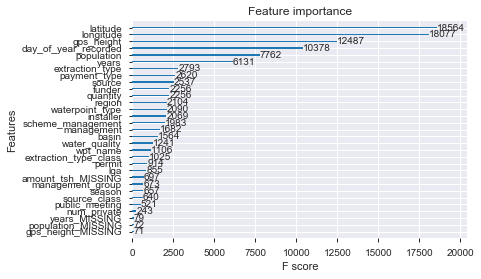

In [94]:
xgb3 = XGBClassifier(
        learning_rate=0.1,
        n_estimators=1000,
        max_depth=9,
        min_child_weight=3,
        gamma=0,
        subsample=0.9,
        colsample_bytree=0.6,
        objective='multi:softprob',
        eval_metric='merror',
        seed=42
)

fit_model(xgb3, X_train_transform, y_train)

In [96]:
X_test_transform = pipe.transform(X_test)

In [101]:
# Generate the Kaggle predictions
y_pred = pd.DataFrame(xgb3.predict(X_test_transform))
print(y_pred)
replace_dict = {
    0: 'functional',
    1: 'functional needs repair',
    2: 'non functional'
}
y_pred = y_pred.replace(replace_dict)
print(y_pred)

# Makes a dataframe with two columns, id and status_group, 
# and writes to a csv file, without the index
submission = sample_submission.copy()
submission['status_group'] = y_pred

filename = 'xgb3_submission.csv'
submission.to_csv(filename, index=False)

       0
0      0
1      0
2      0
3      2
4      0
...   ..
14353  2
14354  0
14355  0
14356  0
14357  2

[14358 rows x 1 columns]
                    0
0          functional
1          functional
2          functional
3      non functional
4          functional
...               ...
14353  non functional
14354      functional
14355      functional
14356      functional
14357  non functional

[14358 rows x 1 columns]


In [102]:
# Generate the Kaggle predictions
y_pred = pd.DataFrame(xgb2.predict(X_test_transform))
y_pred = y_pred.replace(replace_dict)

# Makes a dataframe with two columns, id and status_group, 
# and writes to a csv file, without the index
submission = sample_submission.copy()
submission['status_group'] = y_pred

filename = 'xgb2_submission.csv'
submission.to_csv(filename, index=False)